___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___

# Natural Language Processing Project

In this NLP project I will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. 

I will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.)

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.


## Imports
 **Import pkgs: basic for ML ans for NLP**

In [1]:
#based
import pandas as pd


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

#nlp
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#validation
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Пауль\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
from sklearn.metrics import confusion_matrix

## The Data

**Read the yelp.csv**

In [2]:
df = pd.read_csv('yelp.csv')

**Quick review of data**

In [3]:
df.head(5)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


**Let's create a new column called "text length" which is the number of words in the text column.**

In [6]:
print(df['text'][0])
type(df['text'][0])

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!


str

In [7]:
df["text length"] = df["text"].apply(lambda name: len(name.split()))

In [8]:
df.head(4)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,155
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,257
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,16
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,76


# EDA

Let's explore the data


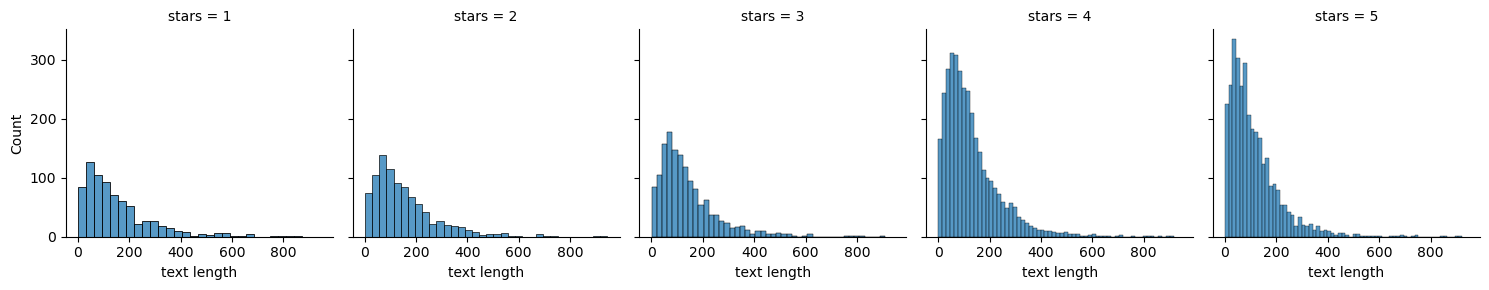

In [9]:
gr = sns.FacetGrid(df,col='stars')

gr.map(sns.histplot, "text length")

**Boxplot of text length for each star category.**

<AxesSubplot:xlabel='stars', ylabel='text length'>

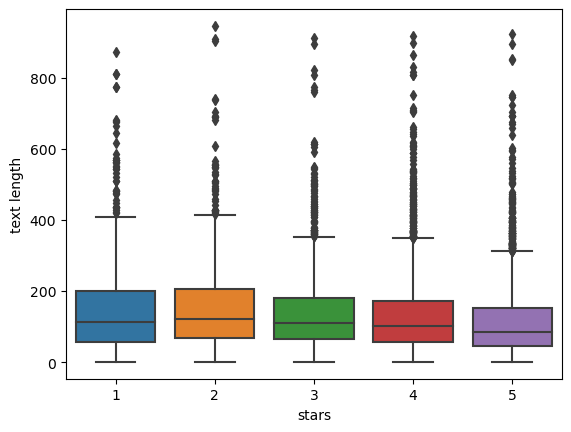

In [10]:
sns.boxplot(y=df["text length"], x=df["stars"])

**Let's check class balance**

<AxesSubplot:xlabel='stars', ylabel='count'>

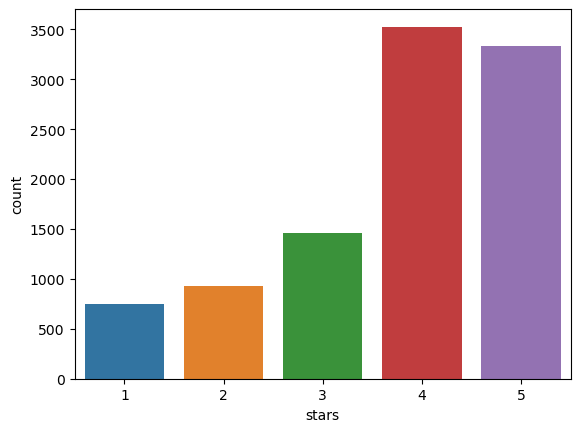

In [11]:
sns.countplot(x=df['stars'])

In [12]:
df.groupby(by='stars').mean()

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,153.953271
2,0.719525,1.563107,0.875944,156.435814
3,0.788501,1.306639,0.694730,140.714579
4,0.954623,1.395916,0.670448,131.174135
5,0.944261,1.381780,0.608631,114.463590


**Get corr between that features**

In [13]:
df.groupby(by='stars').mean().corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.865362
useful,-0.743329,1.000000,0.894506,0.697506
funny,-0.944939,0.894506,1.000000,0.847204
text length,-0.865362,0.697506,0.847204,1.000000


**Then use seaborn to create a heatmap based off that .corr() dataframe:**

<AxesSubplot:>

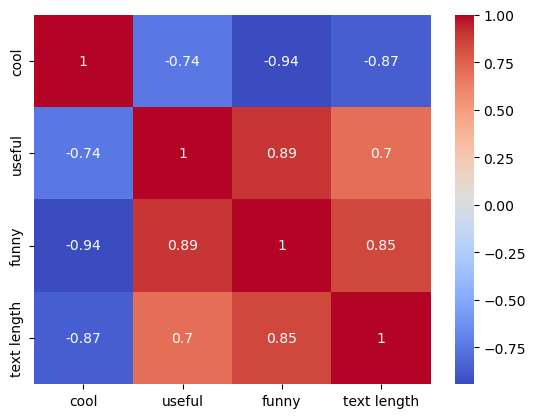

In [14]:
sns.heatmap(df.groupby(by='stars').mean().corr(),cmap='coolwarm', annot=True)

## NLP Classification Task


**Let's create a dataframe called df_15 that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.**

In [15]:
df_15 = df[(df.stars==1) | (df.stars==5)]

In [16]:
X = df_15['text']
y = df_15['stars']

**Will use CountVectorizer form scikit**

In [17]:
vec = CountVectorizer()

In [20]:
X = vec.fit_transform(X)

In [21]:
X

<4086x19183 sparse matrix of type '<class 'numpy.int64'>'
	with 317288 stored elements in Compressed Sparse Row format>

## Train Test Split

Let's split our data into training and testing data.


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training a Model

Let's use MultinomialNB

In [23]:
model = MultinomialNB()

**Now fit nb using the training data.**

In [24]:
model.fit(X_train, y_train)

MultinomialNB()

## Predictions and Evaluations

Time to see how our model did!

**Use the predict method off of nb to predict labels from X_test.**

In [25]:
pred = model.predict(X_test)

** Create a confusion matrix and classification report using these predictions and y_test **

In [27]:
confusion_matrix(y_test, pred)

array([[159,  69],
       [ 22, 976]], dtype=int64)

In [29]:
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



**Great! Let's see what happens if we try to include TF-IDF to this process using a pipeline.**

# Using Text Processing


**Let's create a pipeline with the following steps:CountVectorizer(), TfidfTransformer(),MultinomialNB()**

In [30]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

## Using the Pipeline


### Train Test Split

**Redo the train test split on the yelp_class object.**

In [31]:
X = df_15['text']
y = df_15['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

**Now fit the pipeline to the training data. Remember you can't use the same training data as last time because that data has already been vectorized. We need to pass in just the text and labels**

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Predictions and Evaluation

** Now use the pipeline to predict from the X_test and create a classification report and confusion matrix. You should notice strange results.**

In [35]:
pred = pipeline.predict(X_test)

In [36]:
confusion_matrix(y_test, pred)

array([[  0, 228],
       [  0, 998]], dtype=int64)

In [37]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
